In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy 

## Data F(k)

In [28]:
data = pd.read_excel("data/data.xlsx", usecols = "A, D:E, I:J, N:O, S:T, AC:AD")

T = np.array([
    273 + 22.8,
    273 + 28,
    273 + 38,
    273 + 48,
])

err_T = 0.5

L = 800
err_L = 1

# f_carbon = np.array([])

data

C:\Users\Quark\AppData\Local\Temp\ipykernel_13084\1280408375.py:1: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  data = pd.read_excel("data/data.xlsx", usecols = "A, D:E, I:J, N:O, S:T, AC:AD")


,k,f,F,f.1,F.1,f.2,F.2,f.3,F.3
0,0,200,0,202,0,204,0,207,0
1,1,450,250,453,251,460,256,466,259
2,2,659,459,665,463,675,471,685,478
3,3,872,672,880,678,894,690,907,700
4,4,1087,887,1098,896,1115,911,1131,924
5,5,1303,1103,1315,1113,1336,1132,1357,1150
6,6,1519,1319,1533,1331,1557,1353,1582,1375
7,7,1735,1535,1751,1549,1779,1575,1807,1600
8,8,1951,1751,1969,1767,2000,1796,2031,1824
9,9,2168,1968,2186,1984,2221,2017,2256,2049


In [29]:
def rename_cols(data, T):
    tuples = [
        ("T", "k"),
        # (str(f[i]), "l")
        # (str(f[i]), "L") ...
    ]
    for i in range(0, len(T)):
        tuples.append((str(T[i]), "f"))
        tuples.append((str(T[i]), "F"))

    data.columns = pd.MultiIndex.from_tuples(tuples)
    return data

In [30]:
data = rename_cols(data, T)
data

T 295.8       301.0       311.0       321.0      
     k     f     F     f     F     f     F     f     F
0    0   200     0   202     0   204     0   207     0
1    1   450   250   453   251   460   256   466   259
2    2   659   459   665   463   675   471   685   478
3    3   872   672   880   678   894   690   907   700
4    4  1087   887  1098   896  1115   911  1131   924
5    5  1303  1103  1315  1113  1336  1132  1357  1150
6    6  1519  1319  1533  1331  1557  1353  1582  1375
7    7  1735  1535  1751  1549  1779  1575  1807  1600
8    8  1951  1751  1969  1767  2000  1796  2031  1824
9    9  2168  1968  2186  1984  2221  2017  2256  2049
10  10  2384  2184  2405  2203  2443  2239  2481  2274
11  11  2601  2401  2624  2422  2664  2460  2706  2499
12  12  2817  2617  2841  2639  2887  2683  2932  2725
13  13  3032  2832  3060  2858  3108  2904  3157  2950

In [31]:
def latex_fmt(i, T, names):
    tmp = {
        (str(T[i]), names['f']) : "{:.0f}",
        (str(T[i]), names['F']) : "{:.0f}",
    }
    return tmp

In [35]:
def print_data(data, T, filename):
    names = {'k' : r"$k$",
             'T' : r"$T, ^{\circ} C$",
             'f' : r"$f$, Гц",
             'F' : r"$F$, Гц"
            }

    out_fmt = {(names['T']) : "{:.1f}", names['k'] : "{:.0f}"}

    for i in range(0, len(T)):
        o_list = latex_fmt(i, T, names)
        out_fmt.update(o_list)

    latex = data.rename(
                columns=(names)
            ).style.hide(level=0, axis=0).format(out_fmt, na_rep = "")

    latex.to_latex(
                buf = filename,
                column_format="c" * data.shape[1],
                hrules=True,
                multicol_align = 'c',
                environment = ''
            )
    return latex

In [36]:
print_data(data, T, "F_k.tex")

# Process F(k)

In [90]:
colour = ["red", "blue", "green", "orange", "purple"]

def lin_plot(x, y, xerr, yerr, label = None, i = 1):
    coeffs = np.polyfit(x, y, 1)
    equ = lambda x: coeffs[0] * x + coeffs[1]
    
    x_space = np.linspace(min(x), max(x), 100)
    plt.plot(x_space, equ(x_space), label = label, c = colour[i], linewidth=0.6)
    plt.errorbar(x, y, xerr=0, yerr=yerr, fmt='.', c = colour[i], capsize=2, elinewidth=0.5, markeredgewidth=0.5)
    

In [91]:
mnk_fmt = {
        '$\overline{x}$' : "{:.2e}",
        '$\sigma_x^2$'   : "{:.2e}",
        '$\overline{y}$' : "{:.2f}",
        '$\sigma_y^2$'   : "{:.2e}",
        '$r_{xy}$'       : "{:.2e}",
        '$a$'            : "{:.2f}",
        '$\Delta a$'     : "{:.2f}",
        '$b$'            : "{:.2f}",
        '$\Delta b$'     : "{:.2f}",
}

def least_sq(x, y):
    sx = (x**2).mean() - (x.mean())**2
    sy = (y**2).mean() - (y.mean())**2
    rxy = (y*x).mean() - (y.mean() * x.mean())
    a = rxy / sx
    da = (1/(len(x) - 2) * (sy/sx - a**2))**(0.5)
    b = y.mean() - a * x.mean()
    db = da*(sx + (x.mean())**2)**(1/2)
    dat = pd.DataFrame({
        '$\overline{x}$' : [x.mean()],
        '$\sigma_x^2$'   : [sx],
        '$\overline{y}$' : [y.mean()],
        '$\sigma_y^2$'   : [sy],
        '$r_{xy}$'       : [rxy],
        '$a$'            : [a],
        '$\Delta a$'     : [da],
        '$b$'            : [b],
        '$\Delta b$'     : [db],
    })
    
    return dat, [x.mean(), sx, y.mean(), sy, rxy, a, da, b, db]

In [92]:
def plot_data(data, T, filename):
    a     = np.array([])      # a
    err_a = np.array([])      # errors a

    for i in range(0, len(T)):
        x = data[('T', 'k')]
        y = data[(str(T[i]), 'F')]

        df, dat = least_sq(x, y)
        latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
        # print(latex)

        a     = np.append(a, dat[5])
        err_a = np.append(err_a, dat[6])

        label = r"$T = " + str(T[i]) + r"\; K$"
        lin_plot(x, y, 0, 1, label, i)

    plt.title("$F \; (k)$")
    plt.ylabel(r"$F$, Гц")
    plt.xlabel(r"$k$")
    #plt.grid(True)
    plt.legend(fontsize = 8, framealpha = 0.1)

    print("Coeffs")
    print(a)
    print(err_a)
    plt.savefig(filename)
    
    return a, err_a

Coeffs
[216.43956044 218.34725275 221.83956044 225.3956044 ]
[0.48192378 0.47655495 0.49884785 0.49215559]


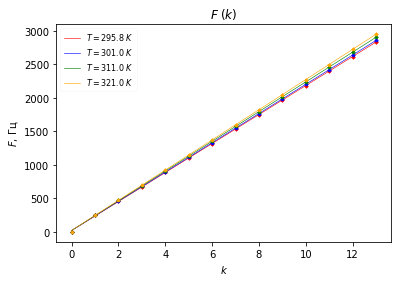

In [93]:
a, err_a = plot_data(data, T, "F_k.pdf")

In [94]:
def print_processed(c, c_err, a, a_err, T, filename):
    
    processed = pd.DataFrame({'T'    : T,
                              'a'    : a,     'err_a'     : err_a,
                              'c'    : c,     'err_c'     : err_c,
                              'gamma': gamma, 'err_gamma' : err_gamma
                            })

    names = {
        'T'     : r"$T, \;^{\circ} C$",

        'a'     : r"$a, \; \text{c}^{-1}$",
        'err_a' : r"$\sigma_a, \; \text{c}^{-1}$",

        'c'     : r"$c$, м/c",
        'err_c' : r"$\sigma_c$, м/с",
        
        'gamma' : r"$\gamma$",
        'err_gamma' : r"$\sigma_{\gamma}$"
    }

    out_fmt = {
        names['T']     : "{:.1f}",

        names['a']     : "{:.2f}",
        names['err_a'] : "{:.2f}",

        names['c']     : "{:.1f}",
        names['err_c'] : "{:.1f}",

        names['gamma']     : "{:.3f}",
        names['err_gamma'] : "{:.3f}",
    }

    latex = processed.rename(
                columns=(names)
            ).style.hide(level=0, axis=0).format(out_fmt).to_latex(
                buf = filename,
                column_format="c" * len(names),
                hrules=True,
                multicol_align = 'c',
                environment = ''
            )
    
    # Evaluating results
    gamma_av = np.mean(gamma)
    err_gamma_av = 0

    for i in range(len(T)):
        err_gamma_av += (gamma[i] - gamma_av)**2

    err_gamma_av **= 0.5

    print("gamma_av:", gamma_av)
    print(err_gamma_av)


In [95]:
c = 2 * a * L / 1000  # mm->m conversion
err_c = c * ((err_a/a)**2 + (err_L/L)**2)**0.5

mu = 0.02898
gamma = mu / (8.31 * T) * c**2
err_gamma = gamma * ((2 * err_c/c)**2 + (err_T/T)**2)**0.5

print_processed(c, err_c, a, err_a, T, "processed_F_k.tex")

gamma_av: 1.4133972571923068
0.001157504243698969


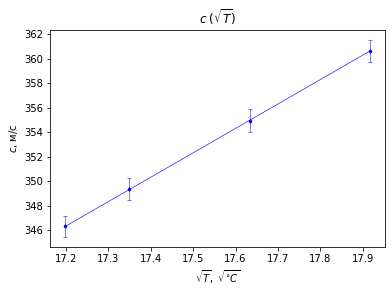

In [96]:
lin_plot(np.sqrt(T), c, err_T/np.sqrt(T), err_c)

plt.title("$c \; (\sqrt{T})$")
plt.ylabel(r"$c$, м/с")
plt.xlabel(r"$\sqrt{T}, \; \sqrt{^{\circ} C}$")

plt.savefig("c_sqrt_T.pdf")
